# Load libraries


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
# Transform features by scaling each feature to a given range.
# This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

from sklearn.metrics import mean_squared_error
# The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

from keras.models import Sequential
# A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

from keras.layers import Dense

from keras.layers import LSTM

# Load the dataset


In [37]:
data = pd.read_csv("bitcoin_ticker.csv")


<ipython-input-37-aa0646d504bf>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("bitcoin_ticker.csv")


In [5]:
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,31-05-2017,01-06-2017 00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,31-05-2017 14:59,31-05-2017 14:59
1,31-05-2017,01-06-2017 00:00,bitflyer,btc_jpy,267098,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880110,31-05-2017 14:59,31-05-2017 14:59
2,31-05-2017,01-06-2017 00:00,korbit,btc_krw,3003500,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,31-05-2017 14:59,31-05-2017 14:59
3,31-05-2017,01-06-2017 00:00,bitstamp,btc_usd,2237.4,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282020,31-05-2017 14:59,31-05-2017 14:59
4,31-05-2017,01-06-2017 00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,31-05-2017 14:59,31-05-2017 14:59


In [38]:
data['rpt_key'].value_counts()

btc_usd       118906
btc_eur        59453
btc_jpy        59453
btc_krw        59453
etc_krw        59453
eth_btc        59453
eth_krw        59453
fx_btc_jpy     59452
ltc_usd        59452
Name: rpt_key, dtype: int64

# Subset USD


In [39]:
df = data.loc[(data['rpt_key']=='btc_usd')]

In [8]:
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,31-05-2017,01-06-2017 00:00,bitstamp,btc_usd,2237.4,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282020,31-05-2017 14:59,31-05-2017 14:59
4,31-05-2017,01-06-2017 00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,31-05-2017 14:59,31-05-2017 14:59
15,01-06-2017,01-06-2017 00:01,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698600,31-05-2017 15:00,31-05-2017 15:00
16,01-06-2017,01-06-2017 00:01,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,31-05-2017 15:00,31-05-2017 15:00
23,01-06-2017,01-06-2017 00:02,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110910,31-05-2017 15:01,31-05-2017 15:01


# Conert datatime_id to data type and filter dates greater than 2017-06-28 00:00:00


In [40]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]
df

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at,datetime
17280,06-06-2017,07-06-2017 00:00,bitstamp,btc_usd,2820.0,2612.27,7.952088,2821.49,2822.04,2608.25,2933.0,21078.15618,06-06-2017 14:59,06-06-2017 14:59,2017-07-06 00:00:00
17281,06-06-2017,07-06-2017 00:00,okcoin,btc_usd,2940.32,2737.00,7.428571,2940.20,2947.55,2684.28,3095.0,4019.75600,06-06-2017 14:59,06-06-2017 14:59,2017-07-06 00:00:00
17282,07-06-2017,07-06-2017 00:01,bitstamp,btc_usd,2820.0,2617.00,7.756974,2817.75,2819.99,2608.25,2933.0,21038.90547,06-06-2017 15:00,06-06-2017 15:00,2017-07-06 00:01:00
17283,07-06-2017,07-06-2017 00:01,okcoin,btc_usd,2946.0,2739.14,7.552005,2946.16,2947.44,2684.28,3095.0,4018.37100,06-06-2017 15:00,06-06-2017 15:00,2017-07-06 00:01:00
17284,07-06-2017,07-06-2017 00:02,bitstamp,btc_usd,2819.99,2617.99,7.715843,2819.95,2819.99,2608.25,2933.0,21035.46284,06-06-2017 15:01,06-06-2017 15:01,2017-07-06 00:02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118901,12-07-2017,12-07-2017 06:50,okcoin,btc_usd,2468.99,2505.00,-1.437525,2453.80,2468.99,2366.00,2540.0,1495.94000,11-07-2017 21:49,11-07-2017 21:49,2017-12-07 06:50:00
118902,12-07-2017,12-07-2017 06:51,bitstamp,btc_usd,2347.1,2334.13,0.555667,2347.01,2350.88,2242.62,2399.0,19447.75827,11-07-2017 21:50,11-07-2017 21:50,2017-12-07 06:51:00
118903,12-07-2017,12-07-2017 06:51,okcoin,btc_usd,2468.99,2505.00,-1.437525,2454.41,2468.99,2366.00,2540.0,1495.89800,11-07-2017 21:50,11-07-2017 21:50,2017-12-07 06:51:00
118904,12-07-2017,12-07-2017 06:52,bitstamp,btc_usd,2346.28,2320.00,1.132759,2345.01,2346.28,2242.62,2399.0,19472.48052,11-07-2017 21:51,11-07-2017 21:51,2017-12-07 06:52:00


In [41]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]

In [42]:
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
17280,2017-07-06 00:00:00,2820.0,2612.27,7.952088,2821.49,2822.04,2608.25,2933.0,21078.15618
17281,2017-07-06 00:00:00,2940.32,2737.00,7.428571,2940.20,2947.55,2684.28,3095.0,4019.75600
17282,2017-07-06 00:01:00,2820.0,2617.00,7.756974,2817.75,2819.99,2608.25,2933.0,21038.90547
17283,2017-07-06 00:01:00,2946.0,2739.14,7.552005,2946.16,2947.44,2684.28,3095.0,4018.37100
17284,2017-07-06 00:02:00,2819.99,2617.99,7.715843,2819.95,2819.99,2608.25,2933.0,21035.46284


# We require only the last value , so we subset that and convert it to numpy array

In [43]:
df = df[['last']]

In [44]:
dataset = df.values
dataset = dataset.astype('float32')

In [45]:
dataset

array([[2820.  ],
       [2940.32],
       [2820.  ],
       ...,
       [2468.99],
       [2346.28],
       [2468.99]], dtype=float32)

Neural networks are sensitive to input data, especiallly when we are using activation functions like sigmoid or tanh activation functions are used. ISo we rescale our data to the range of 0-to-1, using MinMaxScaler

In [46]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [47]:
dataset

array([[0.61023545],
       [0.739573  ],
       [0.61023545],
       ...,
       [0.23291898],
       [0.10101247],
       [0.23291898]], dtype=float32)

In [48]:

train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size,:],dataset[train_size:len(dataset),:]
print(len(train),len(test))

27566 13578


Now let us define the function called create_dataset, which take two inputs,

Dataset - numpy array that we want to convert into a dataset
look_back - number of previous time steps to use as input variables to predict the next time period

In [51]:
# convert an array of values into a dataset matrix

def create_dataset(dataset,look_back=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    dataX.append(a)
    dataY.append(dataset[i+look_back,0])
  return np.array(dataX),np.array(dataY)

In [60]:
look_back=10
trainX,trainY = create_dataset(train,look_back=look_back)
testX,testY = create_dataset(test,look_back=look_back)

In [53]:
trainX

array([[0.61023545, 0.739573  , 0.61023545, ..., 0.75608397, 0.6195228 ,
        0.7608247 ],
       [0.739573  , 0.61023545, 0.74567866, ..., 0.6195228 , 0.7608247 ,
        0.6203079 ],
       [0.61023545, 0.74567866, 0.6102247 , ..., 0.7608247 , 0.6203079 ,
        0.7804532 ],
       ...,
       [0.3516035 , 0.4195404 , 0.3516035 , ..., 0.4079094 , 0.35223794,
        0.4079094 ],
       [0.4195404 , 0.3516035 , 0.4195404 , ..., 0.35223794, 0.4079094 ,
        0.35224867],
       [0.3516035 , 0.4195404 , 0.3516035 , ..., 0.4079094 , 0.35224867,
        0.4079094 ]], dtype=float32)

In [54]:
trainY

array([0.6203079 , 0.7804532 , 0.62420964, ..., 0.35224867, 0.4079094 ,
       0.35257125], dtype=float32)

In [61]:
# reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [56]:
testX


array([[[0.34904528, 0.4195404 , 0.34904528, ..., 0.41952968,
         0.34579897, 0.41952968]],

       [[0.4195404 , 0.34904528, 0.4195404 , ..., 0.34579897,
         0.41952968, 0.34579897]],

       [[0.34904528, 0.4195404 , 0.34338045, ..., 0.41952968,
         0.34579897, 0.41952968]],

       ...,

       [[0.10178638, 0.2220192 , 0.10178638, ..., 0.23291898,
         0.10546279, 0.23291898]],

       [[0.2220192 , 0.10178638, 0.2220192 , ..., 0.10546279,
         0.23291898, 0.10189414]],

       [[0.10178638, 0.2220192 , 0.10178638, ..., 0.23291898,
         0.10189414, 0.23291898]]], dtype=float32)

# Build our Model

In [62]:
model1 = Sequential()
model1.add(LSTM(4,input_shape=(1,look_back)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')
model1.fit(trainX,trainY,epochs=100,batch_size=256,verbose=2)

Epoch 1/100
108/108 - 2s - loss: 0.3331 - 2s/epoch - 18ms/step
Epoch 2/100
108/108 - 0s - loss: 0.0506 - 151ms/epoch - 1ms/step
Epoch 3/100
108/108 - 0s - loss: 0.0099 - 150ms/epoch - 1ms/step
Epoch 4/100
108/108 - 0s - loss: 0.0087 - 166ms/epoch - 2ms/step
Epoch 5/100
108/108 - 0s - loss: 0.0076 - 148ms/epoch - 1ms/step
Epoch 6/100
108/108 - 0s - loss: 0.0066 - 151ms/epoch - 1ms/step
Epoch 7/100
108/108 - 0s - loss: 0.0056 - 150ms/epoch - 1ms/step
Epoch 8/100
108/108 - 0s - loss: 0.0047 - 152ms/epoch - 1ms/step
Epoch 9/100
108/108 - 0s - loss: 0.0038 - 146ms/epoch - 1ms/step
Epoch 10/100
108/108 - 0s - loss: 0.0031 - 154ms/epoch - 1ms/step
Epoch 11/100
108/108 - 0s - loss: 0.0024 - 158ms/epoch - 1ms/step
Epoch 12/100
108/108 - 0s - loss: 0.0018 - 147ms/epoch - 1ms/step
Epoch 13/100
108/108 - 0s - loss: 0.0013 - 142ms/epoch - 1ms/step
Epoch 14/100
108/108 - 0s - loss: 9.2980e-04 - 153ms/epoch - 1ms/step
Epoch 15/100
108/108 - 0s - loss: 6.2837e-04 - 156ms/epoch - 1ms/step
Epoch 16/100


In [63]:
trainPredict = model1.predict(trainX)
testPredict = model1.predict(testX)

424/424 [==============================] - 1s 2ms/step


We have to invert the predictions before calculating error to so that reports will be in same units as our original data

In [64]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY=scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [65]:
trainScore = math.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.81 RMSE
Test Score: 12.76 RMSE


In [66]:
# shift test predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:]=trainPredict

In [67]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(trainPredict)+(look_back * 2) + 1:len(dataset) - 1,:]=testPredict

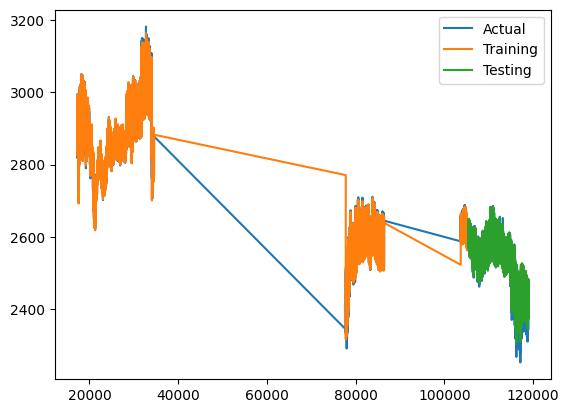

In [68]:
plt.plot(df['last'],label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot,columns=["close"],index=df.index).close,label="Training")
plt.plot(pd.DataFrame(testPredictPlot,columns=["close"],index=df.index).close,label="Testing")
plt.legend(loc="best")
plt.show()